## ロジスティック回帰とは？


https://zenn.dev/sotky/articles/0b3daa2fd5776d

分類予測タスクに使われる回帰モデルです。

ある病気に罹る/罹らない、ある顧客が商品を買うか/買わないか等の２値分類に利用されます。
また、オッズ比によって各説明変数が目的変数へ与える影響を確認できます。
教師データが少なかったり、予測の根拠が欲しいケースで使用されることが多いです。
ここでは、タイタニックデータをサンプルにして解説します。
なお、複数の分類を行う応用モデルもありますが、ここでは単純な2値分類タスクを対象にします。

https://gmo-research.jp/research-column/logistic-regression-analysis
ロジスティック回帰分析は、いくつかの要因（説明変数）から「2値の結果（目的変数）」が起こる確率を説明・予測することができる統計手法で、多変量解析の手法の１つです。

ところで、回帰分析といえば重回帰分析が有名です。
重回帰分析とロジスティック回帰分析の違いは何でしょうか？

簡単に言えば、目的変数が質的か量的かです。

参考：

★
https://www.hinomaruc.com/titanic-dataset-analytics-4-2-logistic-regression/

https://qiita.com/shibata0523/items/894f7e97cf4e648ed56e

正則化のパラメータ C はデフォルト 1.0、最適なパラメータの探索方法 solver はデフォルト liblinear を指定します。

# 決定木との違いは? ★★★

https://www.nttcoms.com/service/research/dataanalysis/decision-tree/


決定木分析と回帰分析はどちらも目的変数を予測するモデルを作っている点では同じです。
そのためどちらも似たような場面と目的で使用されます。
ですが決定木分析と回帰分析は、予測モデルを作るプロセスが異なります。

決定木分析はYes,Noの分岐のみで目的変数を予測します。
計算式などを使わずにシンプルな分岐のみで予測する点が、決定木分析の最大の特徴です。
一方で回帰分析は、y=ax+bのような回帰式と呼ばれる式を使って予測します。
基本的に目的変数と説明変数が比例関係にあるという仮定のもとで予測式を作っている点が、回帰分析の特徴です。
目的変数と説明変数が比例関係にある場合、回帰分析は精度が高くなります。

**一方、回帰分析はデータが正規分布していることを前提とした解析です。
そのためデータが正規分布するように対数変換などの処理を行う必要があります。
外れ値の影響も受けやすいため適切な処理が必要ですし、欠損値を扱うことはできません。**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split

!pip install japanize_matplotlib
import japanize_matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 30.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=8560e9babbd808c57891a92e14c0d788a9fd897a958d20cd25d6c2ff2288c026
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize_matplotlib


In [2]:
def data_prep(df,mode):
    
    df['Cabin'] = df['Cabin'].fillna('Unknown') # 客室データが欠損している場合はUnknownを代入
    df['Deck'] = df['Cabin'].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得
    df = df.drop("Cabin",axis=1)

    df['家族数'] = df['SibSp'] + df['Parch']
    df = df.drop(["SibSp", "Parch"],axis=1)
    
    #df["Fare"] = np.log(df['Fare'])
    df["Fare_log"] = np.log(df['Fare']+1)


    honorific_titles = ["Mr.", "Miss.", "Mrs.", "Master.", "Dr.", "Rev.", "Col.", "Ms.", 
              "Mlle.", "Mme.", "Capt.", "Countess.", "Major.", "Jonkheer.", "Don.", 
             "Dona.", "Sir.", "Lady."]

    # Titleを抽出
    for title in honorific_titles:
        df.loc[df.Name.str.contains(title, regex=False), "honorific_titles"] = title
    
    target_col_list = ["Embarked","Sex","honorific_titles","Deck"]
    if mode == "xgb":#XGBost用ラベルエンコーディング
        le = preprocessing.LabelEncoder()
        for col in target_col_list:
            le.fit(df[col])
            df[col] = le.transform(df[col])
    elif mode == "lgbm":#LightGBM用ラベルエンコーディング
         for col in target_col_list:
            df[col] = df[col].astype("category")
    else:
        pass
        
    #不要カラム削除
    df = df.drop(["Name","Ticket","Fare"],axis=1)
    #df = df.drop(["Name","Ticket","PassengerId"],axis=1)
    
    df = df.rename(columns={
                                'PassengerId':'乗客ID',
                                'Pclass':'チケットクラス',
                                'Sex':'性別',
                                'Age':'年齢',
                                'Fare_log':'乗船料_log',
                                'Embarked':'乗船港',
                                'Deck':'デッキ',
                                'honorific_titles':'敬称'
                               })
    return df


In [3]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")

train = data_prep(train,"xgb")
train = train.rename(columns={'Survived': '生死'})
target_col = "生死"

X_train = train.drop(target_col,axis=1) # 説明変数
y_train = train[target_col] # 目的変数(来店数)

feature_names = X_train.columns.tolist()

X_train['年齢'] =  X_train['年齢'].fillna(-1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   乗客ID     891 non-null    int64  
 1   チケットクラス  891 non-null    int64  
 2   性別       891 non-null    int64  
 3   年齢       891 non-null    float64
 4   乗船港      891 non-null    int64  
 5   デッキ      891 non-null    int64  
 6   家族数      891 non-null    int64  
 7   乗船料_log  891 non-null    float64
 8   敬称       891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB


In [4]:
from sklearn.linear_model import LogisticRegression

# x_trainとY_trainをtrainとvalidに分割
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

clf = LogisticRegression(random_state=0,verbose=0)

#デフォルトの値(max_iter=100)だと警告が出てくるので、iterの回数を上げています。
#ただ上げても精度は変わらなかったです。

model = clf.fit(train_x,train_y)

# 訓練データへの当てはまりを確認
# Return mean accuracy on the given test data and labels.
model.score(train_x,train_y)

0.7893258426966292

In [5]:
# 検証データへの当てはまりを確認
# Return mean accuracy on the given test data and labels.
model.score(valid_x, valid_y)

0.7932960893854749

訓練データと検証データへの当てはまりを確認しましたが、そこまで差がなさそうなのでオーバーフィットはしていなさそうです。
デフォルトの設定の正則化でいい感じに学習してくれているだと思います。

In [6]:
#y_pred = clf.predict(valid_x)
y_pred = model.predict(valid_x)
y_pred

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0])

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import log_loss

print('record num :', valid_y.size)

# 正解率
print('accuracy: ',  round(accuracy_score(y_true=valid_y, y_pred=y_pred),2))
# 適合率
print('precision: ', round(precision_score(y_true=valid_y, y_pred=y_pred),2))
# 再現率
print('recall: ',    round(recall_score(y_true=valid_y, y_pred=y_pred),2))
# f1スコア
print('f1 score: ',  round(f1_score(y_true=valid_y, y_pred=y_pred),2))

#log loss
## https://www.codexa.net/ml-evaluation-cls/
## 続いてLog lossを算出してみましょう。Log lossは確率を入力として分類手法の性能を評価します。ですのでまず、モデルからYが０、１である確率を予測して、一部を表示してみましょう。

y_proba = model.predict_proba(valid_x)

score = log_loss(valid_y,y_proba)
print(f'logloss:{score:.4f}')

record num : 179
accuracy:  0.79
precision:  0.76
recall:  0.68
f1 score:  0.72
logloss:0.4122


In [8]:
#from sklearn.datasets import make_classification
#from sklearn.metrics import ConfusionMatrixDisplay

#ConfusionMatrixDisplay.from_estimator(clf,valid_x,valid_y,cmap="Reds",display_labels=model.classes_,normalize="all")
#plt.show()

TP(正解=1、予測=1)とFP(正解=0、予測=0)の割合を確認。

In [9]:
# モデルパラメーターの確認
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [10]:
model

LogisticRegression(random_state=0)

In [11]:
# 係数確認
coef = pd.DataFrame()
coef["features"] = model.feature_names_in_
coef["coef"] = model.coef_[0]
coef

,features,coef
0,乗客ID,0.000227
1,チケットクラス,-0.177410
2,性別,-2.409743
3,年齢,-0.010015
4,乗船港,0.041966
5,デッキ,-0.008154
6,家族数,-0.363356
7,乗船料_log,0.808453
8,敬称,-0.074563


<BarContainer object of 9 artists>

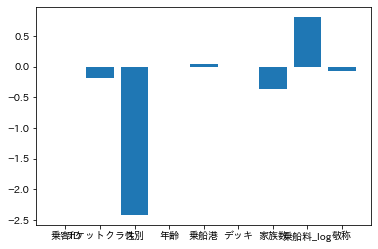

In [12]:
plt.bar(coef["features"], coef["coef"])

<AxesSubplot:xlabel='coef', ylabel='features'>

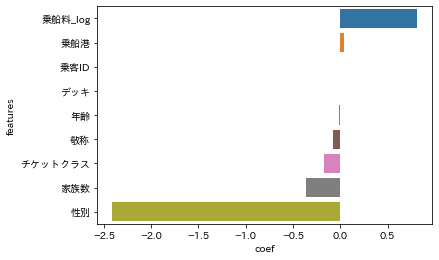

In [13]:
sns.barplot(x='coef',y='features',data=coef.sort_values('coef',ascending=False))

In [14]:
#切片確認
print("Intercept =",model.intercept_[0])

# 提出

X_test = pd.read_csv("/kaggle/input/titanic/test.csv")

X_test = data_prep(X_test,"xgb")

X_test['年齢'] =  X_test['年齢'].fillna(-1)
X_test['乗船料_log'] =  X_test['乗船料_log'].fillna(-1)
X_test.info()

Intercept = 0.25602282929583664
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   乗客ID     418 non-null    int64  
 1   チケットクラス  418 non-null    int64  
 2   性別       418 non-null    int64  
 3   年齢       418 non-null    float64
 4   乗船港      418 non-null    int64  
 5   デッキ      418 non-null    int64  
 6   家族数      418 non-null    int64  
 7   乗船料_log  418 non-null    float64
 8   敬称       418 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 29.5 KB


In [15]:
y_pred = model.predict(X_test)

#データフレームを作成
submission = pd.DataFrame({'PassengerId':X_test['乗客ID'], 'Survived':y_pred})
#submission.to_csv('submission.csv', index=False) 
submission.head() #kaggle Score: 0.72

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# 標準化


https://zenn.dev/sotky/articles/0b3daa2fd5776d
線形回帰などでは標準化などを行う必要がありますが、ロジスティック回帰においては必須ではありません。

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(train_x)
X_valid_normalized = scaler.fit_transform(valid_x)
X_test_normalized = scaler.fit_transform(X_test)

In [17]:
clf = LogisticRegression(random_state=0,max_iter=100,verbose=0)
# fitする
model_normalized = clf.fit(X_train_normalized,train_y)

# テストデータへの当てはまりを確認
# Return the mean accuracy on the given test data and labels.
model_normalized.score(X_train_normalized,train_y)

0.7879213483146067

In [18]:
# 検証データへの当てはまりを確認
# Return the mean accuracy on the given test data and labels.
model_normalized.score(X_valid_normalized,valid_y)

0.8044692737430168

In [19]:
# モデルパラメーターの確認
model_normalized.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [20]:
y_pred = model_normalized.predict(X_valid_normalized)
y_pred

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0])

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import log_loss

# 正解率
print('accuracy: ',  round(accuracy_score(y_true=valid_y, y_pred=y_pred),3))
# 適合率
print('precision: ', round(precision_score(y_true=valid_y, y_pred=y_pred),2))
# 再現率
print('recall: ',    round(recall_score(y_true=valid_y, y_pred=y_pred),2))
# f1スコア
print('f1 score: ',  round(f1_score(y_true=valid_y, y_pred=y_pred),2))

#log loss
## https://www.codexa.net/ml-evaluation-cls/
## 続いてLog lossを算出してみましょう。Log lossは確率を入力として分類手法の性能を評価します。ですのでまず、モデルからYが０、１である確率を予測して、一部を表示してみましょう。

y_proba = model_normalized.predict_proba(X_valid_normalized)

score = log_loss(valid_y,y_proba)
print(f'logloss:{score:.4f}')

accuracy:  0.804
precision:  0.78
recall:  0.68
f1 score:  0.73
logloss:0.4219


In [22]:
# 係数確認
coef = pd.DataFrame()
coef["features"] = model.feature_names_in_
coef["coef"] = model_normalized.coef_[0]
coef

,features,coef
0,乗客ID,0.018829
1,チケットクラス,-0.591148
2,性別,-1.218582
3,年齢,-0.222712
4,乗船港,-0.081976
5,デッキ,-0.064748
6,家族数,-0.426217
7,乗船料_log,0.232029
8,敬称,-0.269829


<AxesSubplot:xlabel='coef', ylabel='features'>

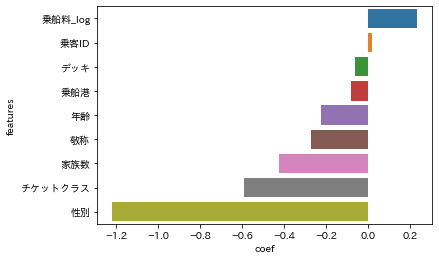

In [23]:
sns.barplot(x='coef',y='features',data=coef.sort_values('coef',ascending=False))
#sns.set_title("偏回帰係数 ")

In [24]:
#0,1の予測結果を出したい場合はpredict、
#確率を算出したい場合はpredict_probaを利用する。

#y_pred = model_normalized.predict(X_test_normalized)

## 閾値を0.5に設定
y_proba = model_normalized.predict_proba(X_test_normalized)
y_pred = (model_normalized.predict_proba(X_test_normalized)[:, 1] > 0.5).astype(int)

#データフレームを作成
submission = pd.DataFrame({'PassengerId':X_test['乗客ID'], 'Survived':y_pred})

submission.to_csv('submission.csv', index=False) #kaggle Score: 0.76555

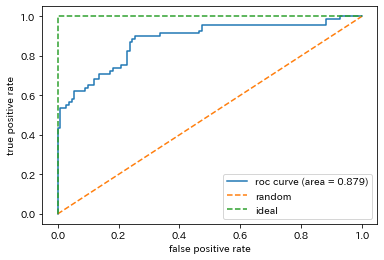

In [25]:
from sklearn.metrics import roc_curve, auc

Y_score = model.predict_proba(X_valid_normalized)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=valid_y, y_score=Y_score)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score
print('auc = ', roc_auc_score(y_true=valid_y, y_score=Y_score))

auc =  0.878524374176548


# ロジスティック回帰における検定の考え方
https://qiita.com/s-nakagawa2/items/a8e4992491d2d314e068

具体的には、kk番目の対数オッズ比（a^ka^k）を0（a^ka^kは必要ない）という仮説を立てて、標本データから得られたa^ka^kの値あるいはa^ka^kを基にした統計量が前章でご紹介した正規分布もしくはχ2χ2分布の仮説の採択領域にあるか否かを確かめます。これは、線形回帰の回帰係数の検定と同じ考え方です。ロジスティック回帰の代表的な検定方法として、Wald検定、尤度比検定、スコア検定の３つがあります。

https://corvus-window.com/python_logistic-regression-analysis/

In [27]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

train = pd.read_csv("/kaggle/input/titanic/train.csv")

train = data_prep(train,"xgb")

train['年齢'] =  train['年齢'].fillna(-1)
train = train.drop("乗客ID",axis=1)
train = train.rename(columns={'Survived': '生死'})
# ロジスティック回帰モデルの推定
#glm関数は一般化線形モデルの推定に用いる関数
#確率分布を記述します．今回は二項分布なのでBinomial()


'''
logistic = smf.glm(formula = "Survived ~ Pclass+Sex+Age+Embarked+Deck+FamilySize+Fare_log+honorific_titles",
                   data = train,
                   family = sm.families.Binomial()).fit()
'''
logistic = smf.glm(formula = "生死 ~ チケットクラス+性別+年齢+乗船港+デッキ+家族数+乗船料_log+敬称",
                   data = train,
                   family = sm.families.Binomial()).fit()


# 推定結果の出力
print(logistic.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     生死   No. Observations:                  891
Model:                            GLM   Df Residuals:                      882
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -397.49
Date:                Tue, 29 Nov 2022   Deviance:                       794.98
Time:                        19:59:41   Pearson chi2:                     881.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3557
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6628      0.946      3.872      0.0

「coef」は偏回帰係数になります．偏回帰係数は0の場合は，その説明変数は推定した回帰モデルに影響を与えないということを意味します．値が正の場合は確率を上げる方向に，負の場合は確率を下げる方向に影響を与えます．

「ｚ」はWald統計量になります．Wald統計量の絶対値が大きいほど，目的変数に影響を与えているということを意味します．

「P>|z|」は偏回帰係数のWald統計量についてのp値になります．p値が有意水準を下回ればその説明変数は有意な偏回帰係数であることが言えます

In [28]:
# 予測値の出力
X_train = train.drop(target_col,axis=1) # 説明変数
pred = logistic.predict(X_train)
print(pred)

0      0.073971
1      0.926710
2      0.654289
3      0.901976
4      0.082154
         ...   
886    0.144131
887    0.949146
888    0.644743
889    0.520541
890    0.094861
Length: 891, dtype: float64
